In [116]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from scipy.special import inv_boxcox
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from collections import Counter
from itertools import combinations

In [117]:
# import data and deserialize models & fitted_lambda to back transform box cox view rate
X_train = pd.read_csv("data/x_train.csv", index_col=0)
X_test = pd.read_csv("data/x_test.csv", index_col=0)
video_df = pd.read_csv("data/videos_prepared.csv")

with open("data/pipelines.pkl", "rb") as f:
    rf_pipeline, xgb_pipeline = pickle.load(f)

with open("data/fitted_lambda.pkl", "rb") as f:
    fitted_lambda = pickle.load(f)

X_test.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
288,0,20,0,11,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
778,0,14,2,7,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
355,1,17,6,2,1,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
481,1,18,5,9,0,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
607,0,19,3,4,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [118]:
# get the shap values of each feature for random forest and xgboost
scaler = rf_pipeline.named_steps["standardscaler"]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
rf_explainer = shap.TreeExplainer(rf_pipeline["randomforestregressor"])
rf_shap_values = pd.DataFrame(rf_explainer.shap_values(X_train_scaled), columns=X_train.columns)

xgb_explainer = shap.TreeExplainer(xgb_pipeline["xgbregressor"])
xgb_shap_values = pd.DataFrame(xgb_explainer.shap_values(X_train_scaled), columns=X_train.columns)

rf_shap_values.head()

,caption,hour_published,weekday_published,month_published,is_short,hd,tag_vegan,tag_veganism,tag_animal rights,tag_earthling ed|earthlinged,...,cat_Gaming,cat_Howto & Style,cat_Music,cat_News & Politics,cat_Nonprofits & Activism,cat_People & Blogs,cat_Pets & Animals,cat_Science & Technology,cat_Sports,cat_Travel & Events
0,-0.003465,0.045373,0.030971,0.005629,0.000589,0.022804,0.004040,-0.015285,0.001416,0.000058,...,0.0,-0.000074,-0.000298,-0.000037,0.002844,0.009143,0.001443,0.000076,0.0,0.0
1,-0.006024,-0.011805,0.053287,-0.022137,-0.000647,0.002949,-0.000768,0.000162,0.000311,0.000119,...,0.0,-0.000335,-0.000054,-0.003519,0.005523,0.001274,0.001864,-0.000008,0.0,0.0
2,0.037255,0.011420,0.003218,0.000906,0.000803,0.003967,-0.001437,-0.002552,0.000518,0.001252,...,0.0,-0.000111,-0.000078,0.000807,0.000997,0.001367,0.000506,0.000019,0.0,0.0
3,-0.004690,0.000369,-0.030775,0.012586,0.001644,0.002240,-0.001721,0.007493,0.000867,0.000060,...,0.0,-0.000191,-0.000052,0.000112,0.003571,-0.002908,0.001628,-0.000008,0.0,0.0
4,-0.002796,0.002739,-0.036088,-0.030476,-0.005149,0.002803,-0.000589,-0.002035,-0.000228,0.000115,...,0.0,-0.000078,-0.000124,-0.000009,-0.001608,0.010010,0.006815,-0.000011,0.0,0.0


In [119]:
# get the average absolute shap values for actionable features with the biggest impact on view rate
def get_top_features_df(shap_values):
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    high_impact_features = pd.DataFrame({"feature": X_train.columns, "mean_abs_shap": mean_shap}).sort_values("mean_abs_shap", ascending=False)
    tags_terms_categories = [col for col in X_train.columns if col.startswith(("tag_", "term_", "cat_"))]
    actionable_features = ["caption", "hour_published", "weekday_published", "month_published", "duration_seconds", "is_short", "hd", "title_length", "description_length"] + tags_terms_categories
    return high_impact_features[high_impact_features["feature"].isin(actionable_features)].head(20)

rf_top_features = get_top_features_df(rf_shap_values)
xgb_top_features = get_top_features_df(xgb_shap_values)
rf_top_features.head()

,feature,mean_abs_shap
212,term_outreach,0.066162
44,term_animal,0.046936
296,term_vegan,0.029065
154,term_instagram,0.029020
301,term_video,0.027355


In [120]:
# add the view rate effect size for the worst to best settings for top actionable features to a dataframe
X_train = X_train.astype("float")

def get_improvement_df(model, feature_df):
    recommendations = {"feature": [], "worst_setting": [], "best_setting": [], "effect_size": []}

    for feature in feature_df["feature"]:
        pdp_results = partial_dependence(estimator=model, X=X_train, features=[feature])

        y_box = pdp_results["average"][0]
        y_original = inv_boxcox(y_box, fitted_lambda).round(2)
        x_vals = pdp_results["grid_values"][0]

        min_idx = np.argmin(y_original)
        max_idx = np.argmax(y_original)

        recommendations["feature"].append(feature)
        recommendations["worst_setting"].append(x_vals[min_idx])
        recommendations["best_setting"].append(x_vals[max_idx])
        recommendations["effect_size"].append(y_original[max_idx] - y_original[min_idx])

    return pd.DataFrame(recommendations)

rf_recommendations = get_improvement_df(rf_pipeline, rf_top_features)
xgb_recommendations = get_improvement_df(xgb_pipeline, xgb_top_features)
rf_recommendations

,feature,worst_setting,best_setting,effect_size
0,term_outreach,0.828466,0.000000,3.24
1,term_animal,0.340997,0.000000,2.17
2,term_vegan,0.032495,0.238300,1.25
3,term_instagram,0.000000,0.129382,2.81
4,term_video,0.000000,0.101955,0.93
5,term_learn,0.071802,0.000000,1.26
6,term_subscribe,0.117510,0.000000,1.65
7,term_gains,0.000000,0.589816,3.51
8,term_youtu,0.000000,0.232388,1.61
9,title_length,51.000000,96.000000,0.81


In [121]:
# inner join rf and xgb on feature name, sort by mean improvement and filter out model disagreements
cross_recommendations = rf_recommendations.merge(xgb_recommendations, on="feature", suffixes=["_rf", "_xgb"])
cross_recommendations["mean_effect_size"] = (cross_recommendations["effect_size_rf"] + cross_recommendations["effect_size_xgb"]) / 2
cross_recommendations.sort_values("mean_effect_size", ascending=False, inplace=True)
larger_agree = (cross_recommendations["worst_setting_rf"] < cross_recommendations["best_setting_rf"]) & (cross_recommendations["worst_setting_xgb"] < cross_recommendations["best_setting_xgb"])
smaller_agree = (cross_recommendations["worst_setting_rf"] > cross_recommendations["best_setting_rf"]) & (cross_recommendations["worst_setting_xgb"] > cross_recommendations["best_setting_xgb"])
cross_recommendations = cross_recommendations[larger_agree | smaller_agree]
cross_recommendations

,feature,worst_setting_rf,best_setting_rf,effect_size_rf,worst_setting_xgb,best_setting_xgb,effect_size_xgb,mean_effect_size
0,term_outreach,0.828466,0.000000,3.24,0.813430,0.000000,7.75,5.495
5,term_gains,0.000000,0.589816,3.51,0.000000,0.266861,5.10,4.305
1,term_animal,0.340997,0.000000,2.17,0.068199,0.000000,5.42,3.795
3,term_instagram,0.000000,0.129382,2.81,0.000000,0.115006,4.22,3.515
8,term_eat,0.000000,0.234398,2.19,0.000000,0.083837,4.31,3.250
6,term_youtu,0.000000,0.232388,1.61,0.000000,0.086852,2.70,2.155
12,term_youtube,0.214270,0.026508,0.50,0.121493,0.000000,2.35,1.425
2,term_vegan,0.032495,0.238300,1.25,0.000000,0.162477,1.53,1.390
9,term_rights,0.137614,0.000000,0.71,0.022666,0.000000,0.94,0.825
4,term_video,0.000000,0.101955,0.93,0.000000,0.055023,0.67,0.800


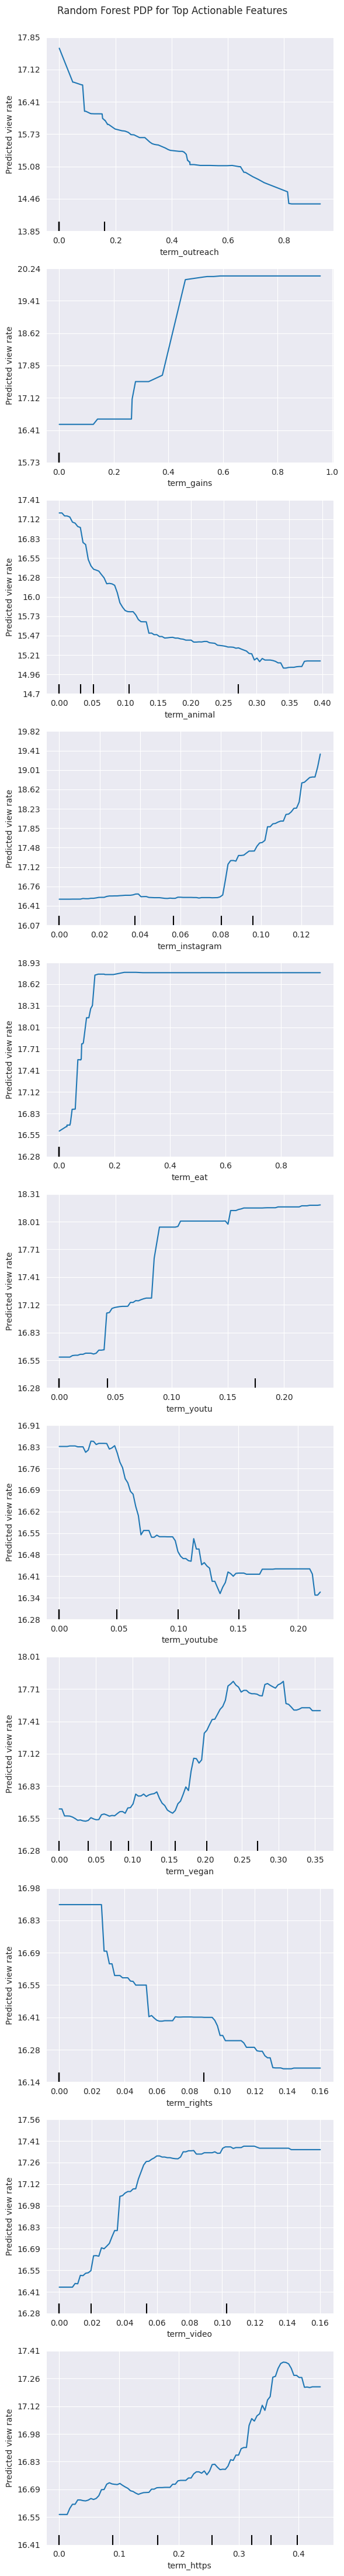

In [52]:
# visualize partial dependence for rf top actionable features
sns.set_style("darkgrid")

def pdp_actionable_features(model, name):
    fig, axes = plt.subplots(11, 1, figsize=(6, 44))
    for i, feature in enumerate(cross_recommendations["feature"]):
        display = PartialDependenceDisplay.from_estimator(estimator=model, X=X_train, features=[feature], ax=axes[i], grid_resolution=100)
        ax = display.axes_.ravel()[0]
        ylabels = ax.get_yticks()
        ax.set_yticks(ylabels)
        ax.set_yticklabels([round(inv_boxcox(y, fitted_lambda), 2) for y in ylabels])
        ax.set_ylabel("Predicted view rate")
    fig.suptitle(f"{name} PDP for Top Actionable Features", y=1)
    plt.tight_layout()

pdp_actionable_features(rf_pipeline, "Random Forest")
plt.savefig("images/rf_pdp_actionable.png", dpi=300)

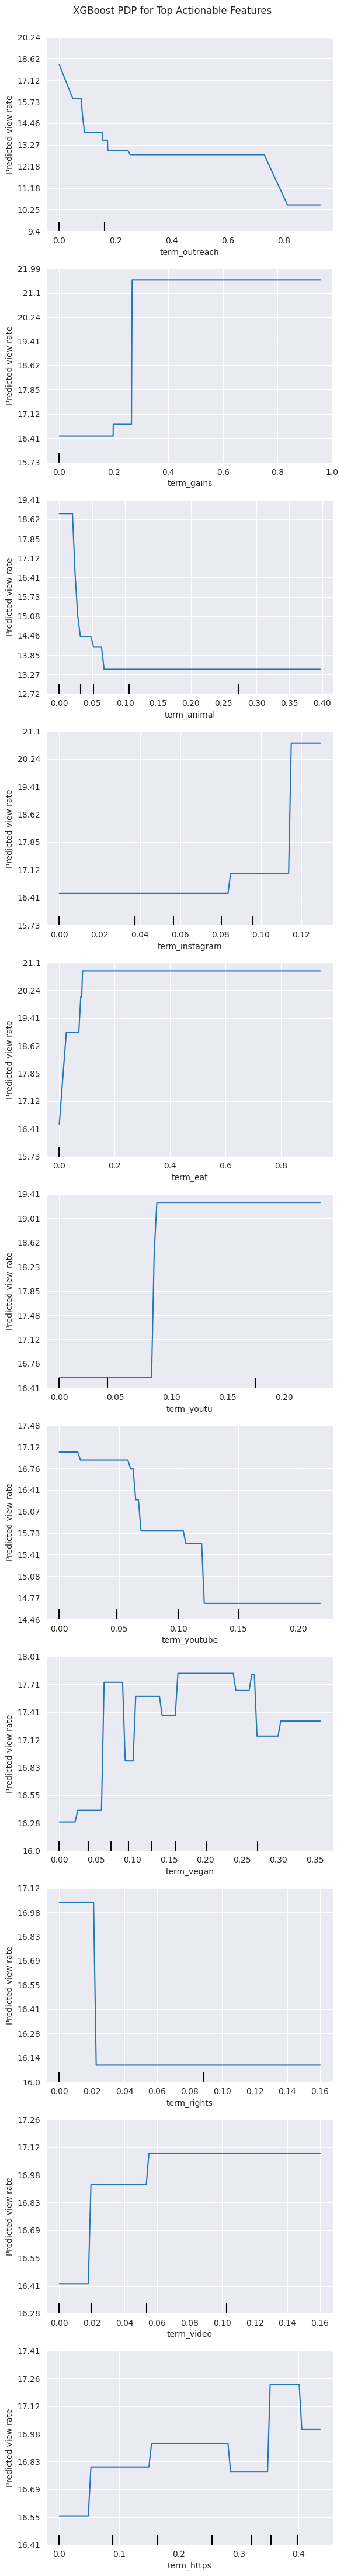

In [53]:
# visualize partial dependence for xgb top actionable features
pdp_actionable_features(xgb_pipeline, "XGBoost")
plt.savefig("images/xgb_pdp_actionable.png", dpi=300)

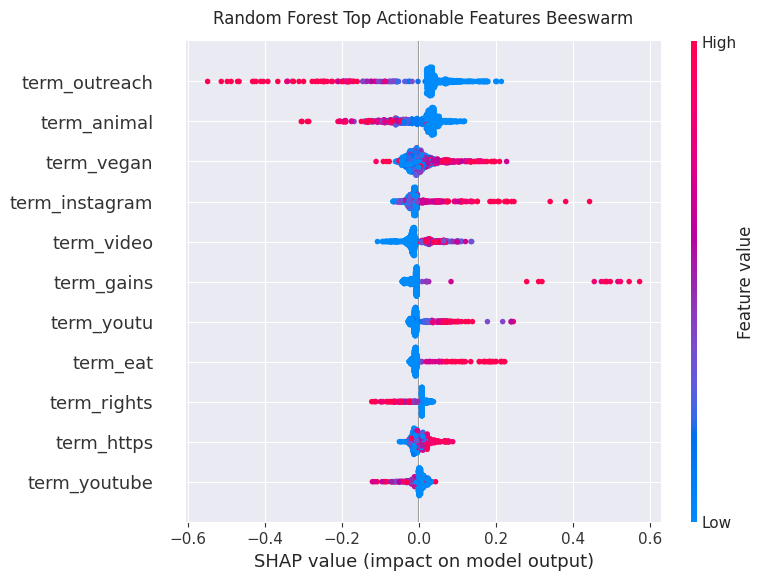

In [54]:
# visualize beeswarm of impact for rf top actionable features
plt.title("Random Forest Top Actionable Features Beeswarm", y=1.02)
cross_actionable_filter = cross_recommendations["feature"].values
shap.summary_plot(rf_shap_values[cross_actionable_filter].values, X_train_scaled[cross_actionable_filter], plot_type="dot", show=False)
plt.savefig("images/rf_beeswarm_actionable.png", dpi=300)

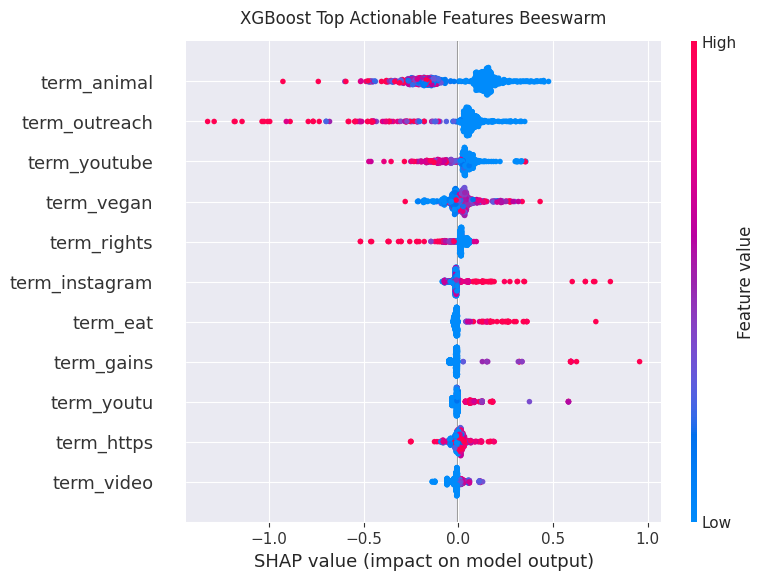

In [55]:
# visualize beeswarm of impact for xgb top actionable features
plt.title("XGBoost Top Actionable Features Beeswarm", y=1.02)
shap.summary_plot(xgb_shap_values[cross_actionable_filter].values, X_train_scaled[cross_actionable_filter], plot_type="dot", show=False)
plt.savefig("images/xgb_beeswarm_actionable.png", dpi=300)

In [129]:
# make dictionary of thresholds of high occurunce rate for each feature and assign 1 for greater is better and 0 for lower is better
thresholds = {}
for feature in cross_recommendations["feature"]:
    row = cross_recommendations[cross_recommendations["feature"] == feature]
    if row["best_setting_rf"].values[0] > row["worst_setting_rf"].values[0]:
        thresholds[feature] = (np.mean([row["best_setting_rf"], row["best_setting_xgb"]]), 1)
    else:
        thresholds[feature] = (0, 0)

thresholds

{'term_outreach': (0, 0),
 'term_gains': (np.float64(0.42833848252002804), 1),
 'term_animal': (0, 0),
 'term_instagram': (np.float64(0.12219432470864908), 1),
 'term_eat': (np.float64(0.15911726206926224), 1),
 'term_youtu': (np.float64(0.15962024305304418), 1),
 'term_youtube': (0, 0),
 'term_vegan': (np.float64(0.200388308135182), 1),
 'term_rights': (0, 0),
 'term_video': (np.float64(0.07848923354966905), 1),
 'term_https': (np.float64(0.3637668428641101), 1)}

In [130]:
# make a dictionary of all video text that is over the threshold for each feature
video_df["description"] = video_df["description"].fillna("")
named_training = pd.merge(video_df[["title", "description"]], X_train, left_index=True, right_index=True)

high_term_text = {}
for feature in cross_recommendations["feature"]:
    if thresholds[feature][1] == 1:
        feature_df = named_training[named_training[feature] >= thresholds[feature][0]].copy()
    else:
        feature_df = named_training[named_training[feature] > thresholds[feature][0]].copy()
    feature_df["text"] = feature_df["title"] + " " + feature_df["description"]
    high_term_text[feature] = feature_df["text"]

high_term_text["term_outreach"].head()

3     Meat Eater Reacts to HEARTBREAKING Activism Fo...
18    INTENSE exchange between Speciesist and Animal...
24                         VEGAN OUTREACH VEGGIE BOWLS 
31    What is the Difference Between Vegetarian and ...
36    Vegan Outreach Fundraising Event in Pasadena, CA 
Name: text, dtype: object

In [131]:
# find the 20 most common terms in association with each feature
common_terms = {}
for feature in high_term_text.keys():
    words = []
    for text in high_term_text[feature]:
        words.extend(text.lower().split())
    common_terms[feature] = Counter(words).most_common(20)

common_terms["term_outreach"]

[('the', 348),
 ('to', 290),
 ('vegan', 214),
 ('and', 176),
 ('of', 167),
 ('for', 142),
 ('outreach', 130),
 ('a', 120),
 ('in', 99),
 ('you', 89),
 ('on', 83),
 ('animal', 81),
 ('is', 72),
 ('with', 71),
 ('this', 67),
 ('i', 66),
 ('edmonton', 59),
 ('-', 56),
 ('my', 51),
 ('are', 48)]

In [132]:
# iterate through top terms and each of their top associated terms, then make dictionaries where both models agree a median increase for the combination, or a median decrease
y_pred_rf = pd.DataFrame(rf_pipeline.predict(X_train), index=X_train.index)
y_pred_xgb = pd.DataFrame(xgb_pipeline.predict(X_train), index=X_train.index)

interaction_increase = {}
interaction_decrease = {}
for feature in cross_recommendations["feature"]:
    for term in common_terms[feature]:
        term_key = f"term_{term[0]}"
        if term_key in X_train.columns and term_key != feature:
            combination_feature = f"{feature[5:]}_{term[0]}"
            high_feature = (X_train[feature] >= thresholds[feature][0]) if thresholds[feature][1] == 1 else (X_train[feature] > thresholds[feature][0])
            high_term = (X_train[term_key] > 0)
            both_high = X_train[high_feature & high_term]
            low_term = X_train[high_feature & ~high_term]
            if len(both_high) < 20 or len(low_term) < 20:
                continue
            rf_difference = y_pred_rf.loc[both_high.index].median().values[0] - y_pred_rf.loc[low_term.index].median().values[0]
            xgb_difference = y_pred_xgb.loc[both_high.index].median().values[0] - y_pred_xgb.loc[low_term.index].median().values[0]
            if rf_difference > 0 and xgb_difference > 0:
                interaction_increase[combination_feature] = (np.mean([rf_difference, xgb_difference]))
            if rf_difference < 0 and xgb_difference < 0:
                interaction_decrease[combination_feature] = (np.mean([rf_difference, xgb_difference]))
interaction_increase

{'animal_vegan': np.float64(2.852101894155555),
 'animal_support': np.float64(3.5742114883529252),
 'youtube_vegan': np.float64(2.956590894792238),
 'youtube_support': np.float64(0.9069588255953231),
 'vegan_support': np.float64(0.44483545207187003),
 'rights_vegan': np.float64(1.758437864272656),
 'video_vegan': np.float64(4.720564606678505)}

In [133]:
interaction_decrease

{'outreach_animal': np.float64(-0.3814568841843454),
 'youtu_david': np.float64(-0.6043443628377618),
 'youtube_animal': np.float64(-2.4446970467610973),
 'vegan_outreach': np.float64(-5.032365395581518),
 'https_support': np.float64(-0.6950524302965269)}

In [134]:
# repeat the cross model median increase/decrease, but for sets of 3 terms

interaction_increase = {}
interaction_decrease = {}
for feature in cross_recommendations["feature"]:
    associated_terms = []
    for term in common_terms[feature]:
        term_key = f"term_{term[0]}"
        if term_key in X_train.columns and term_key != feature:
            associated_terms.append(term[0])
    for t1, t2 in combinations(associated_terms, 2):
        combination_feature = f"{feature[5:]}_{t1}_{t2}"
        high_feature = (X_train[feature] >= thresholds[feature][0]) if thresholds[feature][1] == 1 else (X_train[feature] > thresholds[feature][0])
        high_t1 = (X_train[f"term_{t1}"] > 0)
        high_t2 = (X_train[f"term_{t2}"] > 0)
        all_high = X_train[high_feature & high_t1 & high_t2]
        low_associated_term = X_train[high_feature & (~high_t1 | ~high_t2)]
        if len(all_high) < 10 or len(low_associated_term) < 10:
            continue
        rf_difference = y_pred_rf.loc[all_high.index].median().values[0] - y_pred_rf.loc[low_associated_term.index].median().values[0]
        xgb_difference = y_pred_xgb.loc[all_high.index].median().values[0] - y_pred_xgb.loc[low_associated_term.index].median().values[0]
        if rf_difference > 0 and xgb_difference > 0:
            interaction_increase[combination_feature] = (np.mean([rf_difference, xgb_difference]))
        if rf_difference < 0 and xgb_difference < 0:
            interaction_decrease[combination_feature] = (np.mean([rf_difference, xgb_difference]))
interaction_increase

{'animal_vegan_support': np.float64(4.150351238497165),
 'instagram_vegan_support': np.float64(0.7975873774278701),
 'instagram_follow_support': np.float64(0.7975873774278701),
 'youtube_vegan_support': np.float64(1.387399434725153),
 'rights_animal_vegan': np.float64(1.758437864272656)}

In [135]:
interaction_decrease

{'outreach_vegan_animal': np.float64(-0.47985329196735726),
 'outreach_vegan_edmonton': np.float64(-0.6911716817470137),
 'outreach_animal_edmonton': np.float64(-0.529724886689471),
 'youtu_vegan_david': np.float64(-0.6043443628377618),
 'youtu_support_david': np.float64(-0.7634896379203218),
 'youtu_david_ramms': np.float64(-0.7634896379203218),
 'youtube_vegan_animal': np.float64(-1.2594698320992683),
 'youtube_support_animal': np.float64(-0.5107259694768111),
 'https_vegan_support': np.float64(-0.33891764748637687)}